* How many toxic vs. non-toxic comments are there in the data set?
* Do word lengths tell anything interesting about tendencies toward toxicity?
* What do the toxicity distributions look like? How many are far 
  above/below 0.5?
* What are the distributions of `severe_toxicity`, `obscene`, `threat`,
  `insult`, `identity_attack`, and `sexual_explicit`?

In [1]:
import os
import pandas.io.sql as psql
import sqlalchemy

root = os.path.join(os.pardir, os.pardir)

env = {}
with open(os.path.join(root, ".env"), "r") as envfile:
    while line := envfile.readline():
        line = line.split("#")[0]         # Remove comments.
        line = line.strip()               # Strip extra space.
        name, variable = line.split("=")  # NAME=VARIABLE
        env[name] = variable

conn_string = "postgresql+psycopg2://" \
              "{POSTGRES_USER}:{POSTGRES_PASSWORD}@" \
              "localhost:5432/{POSTGRES_DB}"
conn_string = conn_string.format(**env)

engine = sqlalchemy.create_engine(conn_string)

query = "SELECT t.id" \
              ",t.unprocessed" \
              ",t.processed" \
              ",hr.rating" \
              ",hr.raw_rating " \
        "FROM classifier_app_humanrating hr " \
        "LEFT JOIN classifier_app_text t " \
            "ON t.id = hr.text_id"

comments_df = psql.read_sql(query, engine)

query = "SELECT t.id" \
              ",hr.raw_rating" \
              ",hrc.severe_toxicity" \
              ",hrc.obscene" \
              ",hrc.threat" \
              ",hrc.insult" \
              ",hrc.identity_attack" \
              ",hrc.sexual_explicit" \
        " FROM classifier_app_humanrating hr" \
        " LEFT JOIN classifier_app_humanratingclass hrc" \
            " ON hr.id = hrc.human_rating_id" \
        " LEFT JOIN classifier_app_text t" \
            " ON t.id = hr.id"

hrclass_df = psql.read_sql(query, engine)

In [2]:
comments_df["word_length"] = comments_df["unprocessed"].apply(
    lambda x: len(str(x).split()))

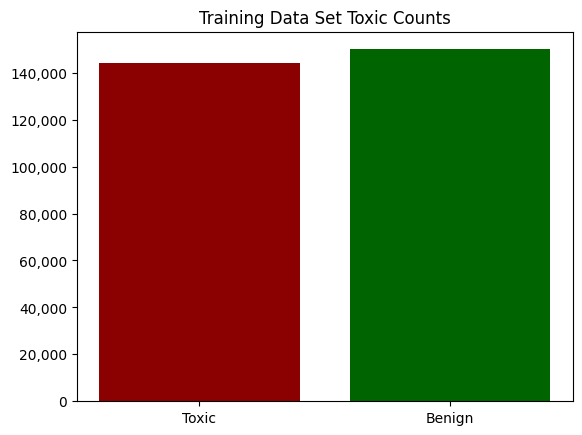

In [3]:
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt

c = Counter(comments_df["rating"])

counts = c.values()
labels = list(map(lambda x: "Toxic" if x else "Benign", c.keys()))
colors = list(map(lambda x: "darkred" if x else "darkgreen", c.keys()))

fig, ax = plt.subplots()

ax.bar(labels, counts, color=colors)
ax.set_title("Training Data Set Toxic Counts")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.show()

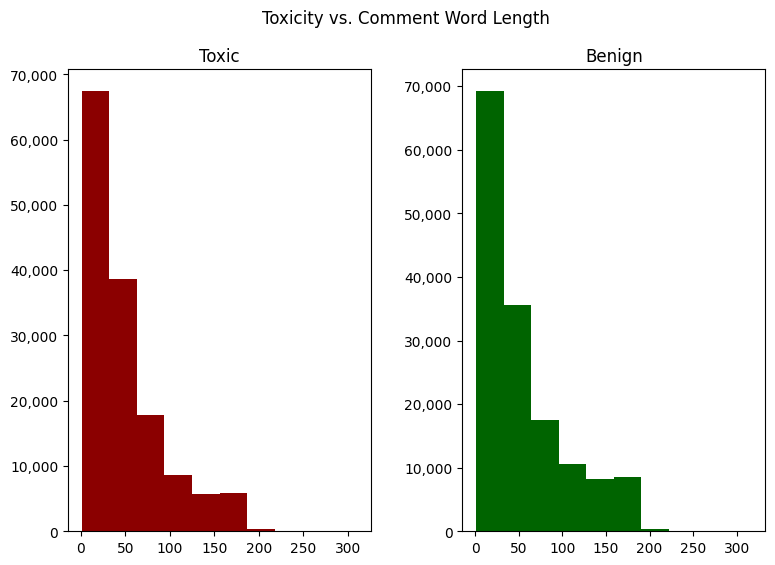

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))

axs[0].hist(comments_df[comments_df["rating"] == True]["word_length"],
            color="darkred")
axs[0].set_title("Toxic")
axs[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
axs[1].hist(comments_df[comments_df["rating"] == False]["word_length"],
            color="darkgreen")
axs[1].set_title("Benign")
axs[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.subplots_adjust(wspace=0.3)
fig.suptitle("Toxicity vs. Comment Word Length")
plt.show()

In [5]:
comments_df[comments_df["rating"] != True]["word_length"].mean()

53.426766666666666

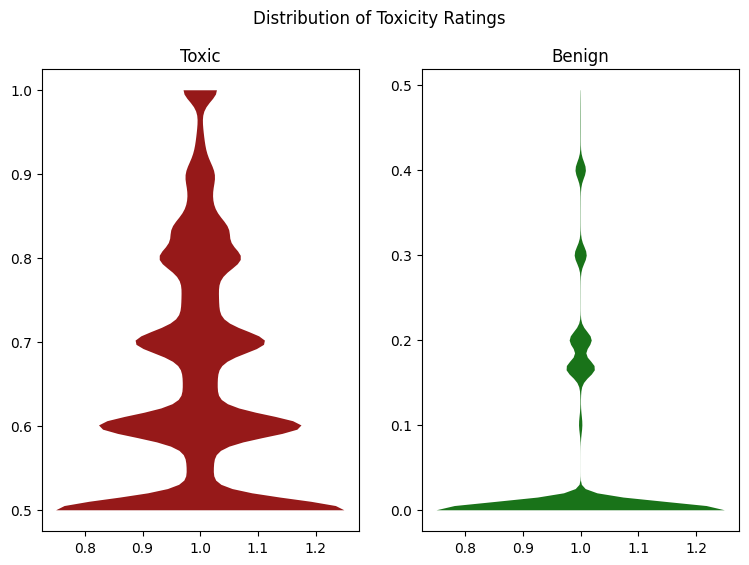

In [6]:
import matplotlib.pyplot as plt

toxic = comments_df[comments_df["rating"] == True]["raw_rating"]
non_toxic = comments_df[comments_df["rating"] == False]["raw_rating"]

fig, axs = plt.subplots(nrows=1, ncols = 2, figsize=(9, 6))
vp = axs[0].violinplot([toxic], 
                       showmeans=False, 
                       showmedians=False, 
                       showextrema=False)
axs[0].set_title("Toxic")

for body in vp["bodies"]:
    body.set_alpha(0.9)
    body.set_facecolor("darkred")

vp = axs[1].violinplot([non_toxic], 
                       showmeans=False, 
                       showmedians=False, 
                       showextrema=False)
axs[1].set_title("Benign")

for body in vp["bodies"]:
    body.set_alpha(0.9)
    body.set_facecolor("darkgreen")

fig.suptitle("Distribution of Toxicity Ratings")
plt.show()

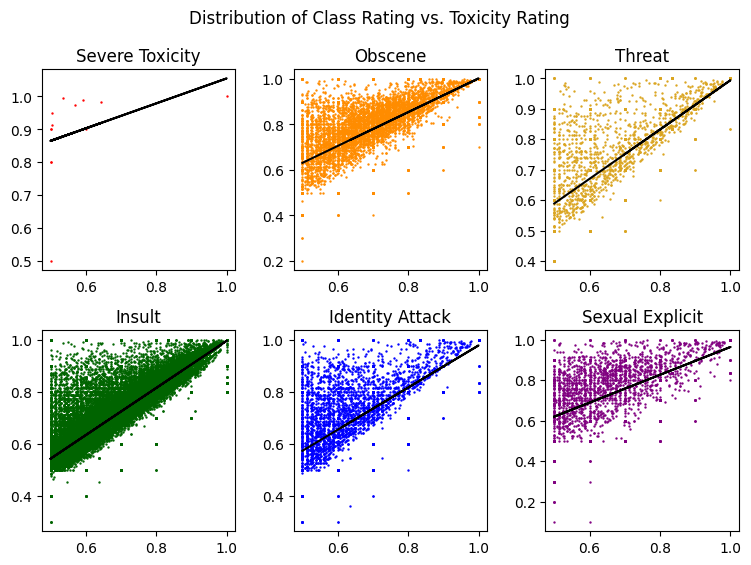

In [7]:
import matplotlib.pyplot as plt
import numpy as np

categories = [
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_attack",
    "sexual_explicit"
]

colors = [
    "red",
    "darkorange",
    "goldenrod",
    "darkgreen",
    "blue",
    "purple"
]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9,6))

for i, category in enumerate(categories):
    row = i // 3
    col = i - 3 if i >= 3 else i
    ax = axs[row][col]
    data = hrclass_df[hrclass_df[category] >= 0.5]
    x, y = data[category], data["raw_rating"]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.scatter(x, y, s=0.5, c=colors[i])
    ax.plot(x, p(x), "black")
    ax.set_title(" ".join(category.split("_")).title())

plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig.suptitle("Distribution of Class Rating vs. Toxicity Rating")
plt.show()